In [8]:
import pandas as pd
import matplotlib.pyplot as plt  # Asegúrate de importar matplotlib
import seaborn as sns  # Para usar heatmap
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Input, Concatenate, Embedding, Flatten, Reshape, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder


Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0100 - loss: 5.4889 - val_accuracy: 0.0553 - val_loss: 5.2344 - learning_rate: 1.0000e-04
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0396 - loss: 5.2844 - val_accuracy: 0.1256 - val_loss: 5.0097 - learning_rate: 1.0000e-04
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0822 - loss: 5.0999 - val_accuracy: 0.1806 - val_loss: 4.7839 - learning_rate: 1.0000e-04
Epoch 4/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1201 - loss: 4.8724 - val_accuracy: 0.2070 - val_loss: 4.5649 - learning_rate: 1.0000e-04
Epoch 5/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1471 - loss: 4.6643 - val_accuracy: 0.2173 - val_loss: 4.3402 - learning_rate: 1.0000e-04
Epoch 6/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1601 - loss: 4.4953 - val_accuracy: 0.2393 - val_loss: 4.1350 - learning_rate: 1.0000e-04
Epoch 7/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc

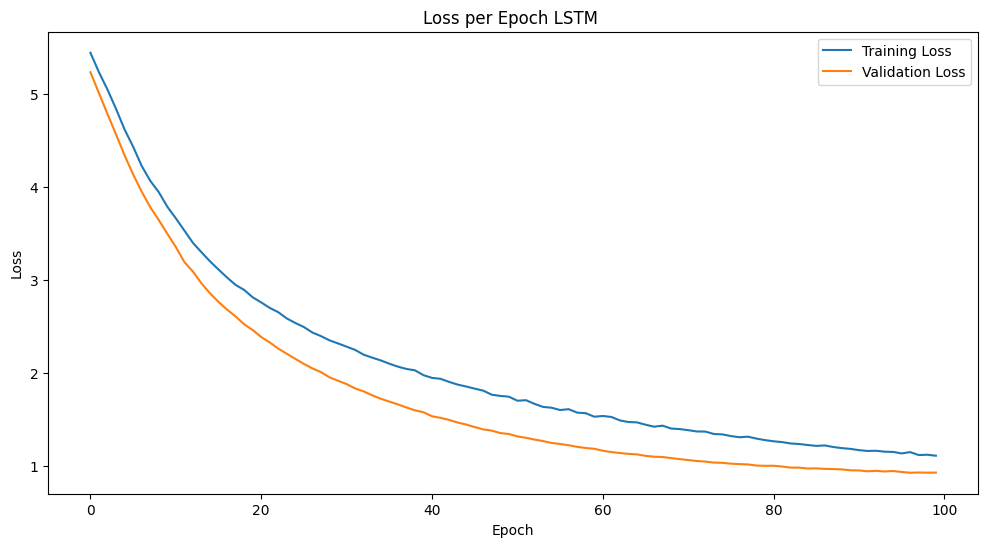

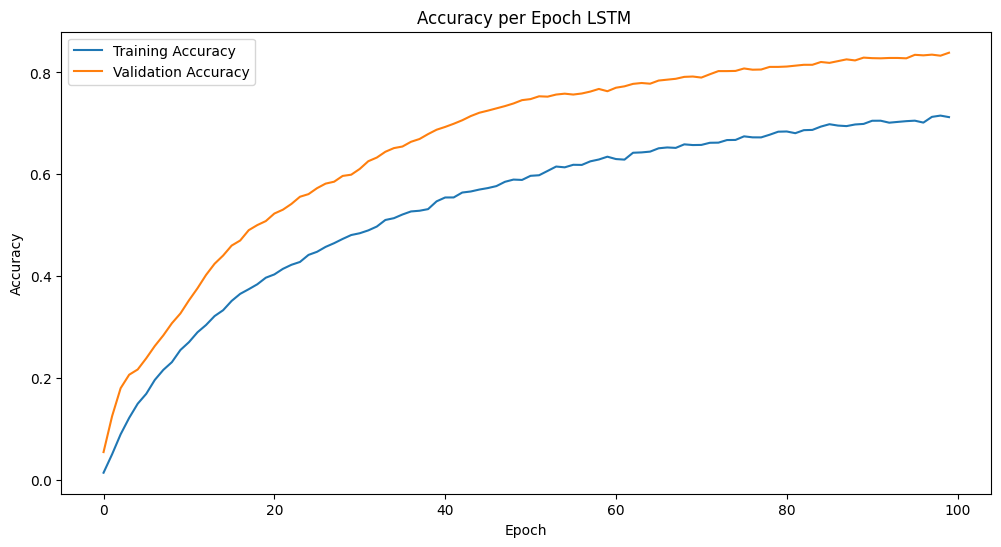

In [9]:
# Cargo el dataset
file_path = r'dataset_elpino.csv'  # Reemplazo con la ruta a mi archivo CSV
data = pd.read_csv(file_path, delimiter=';')

# Creo una lista con los nombres de las columnas de diagnóstico
diagnosticos_cols = [f'Diag {i:02d} Principal (cod+des)' if i == 1 else f'Diag {i:02d} Secundario (cod+des)' for i in range(1, 36)]  # Hasta Diag 05, ajusto si hay más
# Creo una lista con los nombres de las columnas de procedimiento
procedimientos_cols = [f'Proced {i:02d} Principal (cod+des)' if i == 1 else f'Proced {i:02d} Secundario (cod+des)' for i in range(1, 31)]  # Hasta proc 05, ajusto si hay más

# Creo un nuevo DataFrame para almacenar los códigos extraídos
data2 = data.copy()  # Copio el dataset original

# Itero sobre todas las columnas de diagnósticos y extraigo el código antes del guion '-'
for col in diagnosticos_cols:
    data2[col] = data2[col].str.split('-', expand=True)[0]

# Itero sobre todas las columnas de procedimientos y extraigo el código antes del guion '-'
for col in procedimientos_cols:
    data2[col] = data2[col].str.split('-', expand=True)[0]

# Convierto la columna 'Sexo (Desc)' a numérica (Hombre=1, Mujer=0)
data2['Sexo (Desc)'] = data['Sexo (Desc)'].map({'Hombre': 1, 'Mujer': 0})
data2['GRD'] = data['GRD'].str.split('-', expand=True)[0]
# Utilizo .loc para evitar el SettingWithCopyWarning
data2.loc[:, 'GRD'] = data['GRD'].str[:5]


# Defino las variables categóricas y numéricas
categorical_columns = ['Diag 01 Principal (cod+des)', 'Diag 02 Secundario (cod+des)', 
                       'Proced 01 Principal (cod+des)', 'Proced 02 Secundario (cod+des)']
numerical_columns = ['Edad en años', 'Sexo (Desc)']

# Normalizo las variables numéricas
scaler = StandardScaler()
data2[numerical_columns] = scaler.fit_transform(data2[numerical_columns])

# Aplico LabelEncoder a todas las columnas categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data2[col] = le.fit_transform(data2[col].astype(str))
    label_encoders[col] = le

# Codifico la variable objetivo (GRD)
le_grd = LabelEncoder()
data2['GRD'] = le_grd.fit_transform(data2['GRD'].astype(str))

# Verifico el número de clases
num_classes = len(np.unique(data2['GRD']))

# Divido en características (X) y objetivo (y)
X = data2[categorical_columns + numerical_columns]
y = data2['GRD']

# Divido en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convierto X_train y X_test a arrays de NumPy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Defino dimensiones del embedding para las variables categóricas
embedding_dim = 10

# Defino las entradas para cada característica categórica
inputs = []
embeddings = []

for col in categorical_columns:
    input_cat = Input(shape=(1,), name=f"input_{col}")
    embedding_cat = Embedding(input_dim=data2[col].nunique() + 1, output_dim=embedding_dim)(input_cat)
    embedding_cat = Flatten()(embedding_cat)
    inputs.append(input_cat)
    embeddings.append(embedding_cat)

# Entrada para las variables numéricas (edad, sexo, etc.)
input_num = Input(shape=(len(numerical_columns),), name="input_numerical")
inputs.append(input_num)
embeddings.append(input_num)

# Concateno todas las entradas
x = Concatenate()(embeddings)

# Cambio la forma para adecuarse a la entrada 3D que espera LSTM
x = Reshape((1, x.shape[1]))(x)

# Capa LSTM
x = LSTM(64, return_sequences=False)(x)

# Capas densas con Batch Normalization y Dropout para estabilizar el entrenamiento
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


#--------------------------------------
# Capa de salida con el número correcto de clases
output = Dense(num_classes, activation='softmax')(x)


# Creo el modelo
model = Model(inputs=inputs, outputs=output)

# Compilo el modelo con una tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks para detener el entrenamiento temprano y ajustar la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Preparo las entradas para el modelo
X_train_list = [X_train[:, i].reshape(-1, 1) for i in range(len(categorical_columns))] + [X_train[:, -len(numerical_columns):]]
X_test_list = [X_test[:, i].reshape(-1, 1) for i in range(len(categorical_columns))] + [X_test[:, -len(numerical_columns):]]

# Entreno el modelo
history = model.fit(X_train_list, y_train, 
                    epochs=100,  
                    batch_size=32, 
                    validation_data=(X_test_list, y_test), 
                    callbacks=[early_stopping, reduce_lr])

# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_list, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Visualizo las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch LSTM ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizo las precisiones
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch LSTM ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report

# Predecir las probabilidades para el conjunto de prueba
y_pred_probabilities = model.predict(X_test_list)

# Convertir las probabilidades a clases predichas
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Asegúrate de que y_test sea un array de NumPy si es necesario
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_classes_array = np.array(y_pred_classes)

# Obtener las clases presentes en y_test para asegurar que coincidan con las predicciones
present_classes = np.unique(y_test_array)

# Generar el reporte de clasificación solo con las clases presentes en y_test
report = classification_report(
    y_test_array, 
    y_pred_classes_array, 
    labels=present_classes, 
    target_names=[le_grd.classes_[i] for i in present_classes]
)
print(report)



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

       01411       0.00      0.00      0.00         2
       01413       0.50      0.62      0.56         8
       01414       0.98      1.00      0.99        52
       01416       1.00      1.00      1.00         6
       01417       0.00      0.00      0.00         1
       01421       0.00      0.00      0.00         1
       01422       0.89      1.00      0.94        24
       01423       0.60      1.00      0.75         6
       01424       0.97      0.97      0.97        29
       01425       0.00      0.00      0.00         1
       01426       0.00      0.00      0.00         3
       02410       0.00      0.00      0.00         2
       02412       0.00      0.00      0.00         2
       03115       0.00      0.00      0.00         1
       03120       0.00      0.00      0.00         2
       03412       0.00      0.00      0.00         1
       03413       0.44      0.73      0.5

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


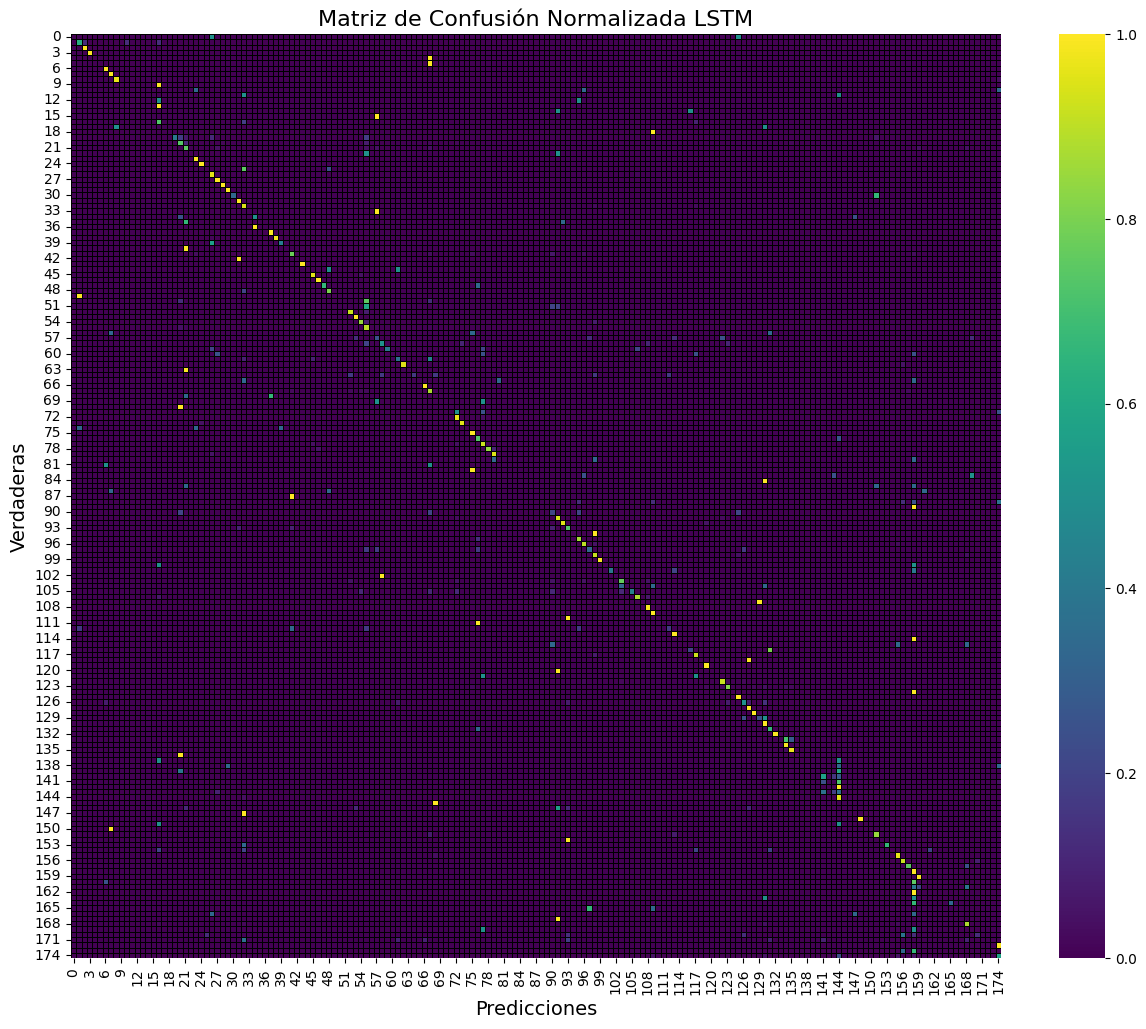

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generar las predicciones del modelo
y_pred = model.predict(X_test_list)
y_pred_classes = np.argmax(y_pred, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes, normalize='true')

# Configurar el tamaño de la figura para que se ajuste bien a la visualización
plt.figure(figsize=(15, 12))

# Utilizar un mapa de colores más contrastante y reducir el tamaño de las celdas
sns.heatmap(cm, annot=False, cmap='viridis', cbar=True, linewidths=0.5, linecolor='black')

# Ajustar las etiquetas de los ejes para que se vean mejor
plt.xlabel('Predicciones', fontsize=14)
plt.ylabel('Verdaderas', fontsize=14)
plt.title('Matriz de Confusión Normalizada LSTM', fontsize=16)

# Rotar las etiquetas de los ejes si es necesario para que se ajusten
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.show()

In [12]:
#6. Análisis de Errores

# Convertir y_test a array si es necesario
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

# Invertir las etiquetas codificadas para obtener las etiquetas originales
y_test_labels = le_grd.inverse_transform(y_test_array)
y_pred_labels = le_grd.inverse_transform(y_pred_classes)

# Contadores de predicciones correctas e incorrectas
correctas = 0
incorrectas = 0

# Revisar cada predicción
for i in range(len(y_test_labels)):
    if y_test_labels[i] == y_pred_labels[i]:
        correctas += 1
        print(f"Correcto: Etiqueta verdadera: {y_test_labels[i]}, Predicción: {y_pred_labels[i]}")
    else:
        incorrectas += 1
        print(f"*Incorrecto: Etiqueta verdadera: {y_test_labels[i]}, Predicción: {y_pred_labels[i]}")

# Mostrar totales de predicciones correctas e incorrectas
print(f"Total predicciones correctas: {correctas}")
print(f"Total predicciones incorrectas: {incorrectas}")

Correcto: Etiqueta verdadera: 15817, Predicción: 15817
Correcto: Etiqueta verdadera: 06112, Predicción: 06112
Correcto: Etiqueta verdadera: 06113, Predicción: 06113
Correcto: Etiqueta verdadera: 06112, Predicción: 06112
Correcto: Etiqueta verdadera: 05419, Predicción: 05419
Correcto: Etiqueta verdadera: 11412, Predicción: 11412
Correcto: Etiqueta verdadera: 04415, Predicción: 04415
*Incorrecto: Etiqueta verdadera: 15813, Predicción: 15817
Correcto: Etiqueta verdadera: 06120, Predicción: 06120
Correcto: Etiqueta verdadera: 14612, Predicción: 14612
*Incorrecto: Etiqueta verdadera: 11140, Predicción: 11120
*Incorrecto: Etiqueta verdadera: 08102, Predicción: 05420
Correcto: Etiqueta verdadera: 05419, Predicción: 05419
Correcto: Etiqueta verdadera: 05419, Predicción: 05419
Correcto: Etiqueta verdadera: 04418, Predicción: 04418
Correcto: Etiqueta verdadera: 11413, Predicción: 11413
Correcto: Etiqueta verdadera: 09150, Predicción: 09150
Correcto: Etiqueta verdadera: 04411, Predicción: 04411
*